In [1]:
!pip3 install matplotlib

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Load the dataset
raw_data = pd.read_csv('winequality-white.csv', sep='\t', header=None)  # Using tab as separator

# Split the first column (which contains all attributes) by semicolons
df_split = raw_data[0].str.split(';', expand=True)

# Extract the header from the first row and create a list of attribute names
attribute_names = df_split.iloc[0].str.replace('"', '', regex=False).str.strip()

# Create a DataFrame from the remaining rows (excluding the first one)
df = df_split[1:]

# Assign the header to the DataFrame
df.columns = attribute_names

# Convert only the numeric rows to float, using `pd.to_numeric` to handle conversion
df = df.apply(pd.to_numeric, errors='coerce')
# Check the resulting DataFrame
print("Split DataFrame shape:", df.shape)

Split DataFrame shape: (4898, 12)


In [77]:
# Set a random seed for reproducibility
np.random.seed(42)
# Assuming the last column is the target variable
X = df.iloc[:, :-1]   # All columns except the last one
Y = df.iloc[:, -1]    # The last column is the target

# Check the split data
print("Feature Matrix (X) shape:", X.shape)
print("Target Vector (Y) shape:", Y.shape)

# Define your percentages
train_size = 0.7    # 70% for training
valid_size = 0.15   # 15% for validation
test_size = 0.15    # 15% for testing

# Compute the number of rows for each subset
n = len(X)
train_end = int(train_size * n)
valid_end = int((train_size + valid_size) * n)

# Shuffle the indices for randomness
indices = np.random.permutation(n)

# Split the data based on indices
train_indices = indices[:train_end]
valid_indices = indices[train_end:valid_end]
test_indices = indices[valid_end:]

# Create the train, validation, and test sets
X_train, Y_train = X.iloc[train_indices], Y.iloc[train_indices]
X_valid, Y_valid = X.iloc[valid_indices], Y.iloc[valid_indices]
X_test, Y_test = X.iloc[test_indices], Y.iloc[test_indices]

# Check the sizes of each set
print("Training set size:", X_train.shape, Y_train.shape)
print("Validation set size:", X_valid.shape, Y_valid.shape)
print("Test set size:", X_test.shape, Y_test.shape)

Feature Matrix (X) shape: (4898, 11)
Target Vector (Y) shape: (4898,)
Training set size: (3428, 11) (3428,)
Validation set size: (735, 11) (735,)
Test set size: (735, 11) (735,)


In [3]:
# Finding the best alpha for L2 and L1 regularization 
def find_best_alpha(X_train, Y_train, X_valid, Y_valid, reg_type):
    # Define candidate regularization parameters (alpha values)
    alphas = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
    
    # To store validation errors for each alpha
    validation_errors = []
    
    m, n = X_train.shape  # m = number of examples, n = number of features
    
    for alpha in alphas:
        # Initialize weights to zeros (or small random values)
        W = np.zeros(n)
        
        # Train the model using gradient descent for each alpha
        epochs = 100
        learning_rate = 0.001
        
        for epoch in range(epochs):
            # Predictions for training set
            Y_train_hat = np.dot(X_train, W)
            
            # Calculate gradients for L2 (Ridge) or L1 (Lasso) regularization
            if reg_type == 'l2':  # Ridge (L2)
                gradient = (2 / m) * np.dot(X_train.T, (Y_train_hat - Y_train)) + 2 * alpha * W
            elif reg_type == 'l1':  # Lasso (L1)
                gradient = (2 / m) * np.dot(X_train.T, (Y_train_hat - Y_train)) + alpha * np.sign(W)
            else:
                raise ValueError("reg_type must be 'l1' or 'l2'.")
            
            # Update weights using gradient descent
            W -=learning_rate * gradient
        
        # Validate the model on the validation set
        Y_valid_hat = np.dot(X_valid, W)
        
        # Compute the validation MSE
        mse = np.mean((Y_valid - Y_valid_hat) ** 2)
        validation_errors.append(mse)
    
    # Find the best alpha (with the lowest validation error)
    best_alpha = alphas[np.argmin(validation_errors)]
    return best_alpha

In [4]:
# Batch Gradient Descent without Regularization, with L1 and L2 Regularization
def batch_gradient_descent(X_train, Y_train, X_valid, Y_valid, learning_rate, epochs, reg_type='none'):
    m, n = X_train.shape
    W = np.zeros(n + 1) # Weight vector initializatio- we started with a zero vector
    X_train = np.c_[np.ones((m, 1)), X_train] # Add bias term for train set
    X_valid = np.c_[np.ones((X_valid.shape[0], 1)), X_valid]  # Add bias term for valid set

    best_alpha = None
    if reg_type in ['l1', 'l2']:
        best_alpha = find_best_alpha(X_train, Y_train, X_valid, Y_valid, reg_type)
        print(f"Best regularization parameter (alpha) for {reg_type}: {best_alpha}")

    for epoch in range (epochs):
        Y_hat = np.dot(X_train,W) # Compute predictions
        mse = np.mean((Y_train - Y_hat) ** 2) # Mean Squared Error

        if reg_type == 'l2':
            gradient = (2/m) * np.dot(X_train.T, (Y_hat - Y_train)) + 2*best_alpha*W # Gradient
        elif reg_type == 'l1':
            gradient = (2/m) * np.dot(X_train.T, (Y_hat - Y_train)) + best_alpha*np.sign(W) # Gradient
        else:
            gradient = (2/m) * np.dot(X_train.T, (Y_hat - Y_train)) # Gradient
        
        W = W-learning_rate * gradient  # Update weights

        if epoch % 10 == 0:
            print(f'Epoch {epoch}: MSE = {mse}')
            
    return W, Y_hat, mse

In [78]:
# Batch without Regularization
W_batch, Y_hat, mse = batch_gradient_descent(X_train, Y_train, X_valid, Y_valid, learning_rate=0.00001, epochs=8000, reg_type='none')
# Use np.set_printoptions to control the display format
np.set_printoptions(suppress=True)
print("Weights from Batch GD without Regularization:", np.round(W_batch,5))
#We tried 100,000 interations and found that after almost 8000 iterations, MSE was almost stagnant around 0.67. 

Epoch 0: MSE = 35.52246207701283
Epoch 10: MSE = 4.191994344761329
Epoch 20: MSE = 4.165121407154795
Epoch 30: MSE = 4.138668378344669
Epoch 40: MSE = 4.112425354184204
Epoch 50: MSE = 4.086390050596944
Epoch 60: MSE = 4.06056024772423
Epoch 70: MSE = 4.034933785051889
Epoch 80: MSE = 4.0095085581405465
Epoch 90: MSE = 3.984282515568319
Epoch 100: MSE = 3.9592536560717706
Epoch 110: MSE = 3.9344200258719875
Epoch 120: MSE = 3.9097797161734777
Epoch 130: MSE = 3.885330860824432
Epoch 140: MSE = 3.8610716341276574
Epoch 150: MSE = 3.837000248792175
Epoch 160: MSE = 3.8131149540161693
Epoch 170: MSE = 3.7894140336925775
Epoch 180: MSE = 3.7658958047292024
Epoch 190: MSE = 3.742558615475749
Epoch 200: MSE = 3.719400844250726
Epoch 210: MSE = 3.6964208979615747
Epoch 220: MSE = 3.6736172108118885
Epoch 230: MSE = 3.650988243089935
Epoch 240: MSE = 3.628532480033125
Epoch 250: MSE = 3.606248430763394
Epoch 260: MSE = 3.5841346272888295
Epoch 270: MSE = 3.5621896235671535
Epoch 280: MSE = 3.5

In [79]:
# Batch L2 Regularization
#W_batch_l2 = batch_gradient_descent_l2(X_train, Y_train, learning_rate=0.00001, epochs=10000)
W_batch_l2, Y_hat_l2, mse_l2 = batch_gradient_descent(X_train, Y_train, X_valid, Y_valid, learning_rate=0.00001, epochs=10000, reg_type='l2')
print("Weights from Batch GD with L2 Regularization:", np.round(W_batch_l2,5))
# We tried 100,000 interations and found that after almost 10000 iterations, value of the cost function was almost stagnant around 0.68#Define learning rate

Best regularization parameter (alpha) for l2: 0.0001
Epoch 0: MSE = 35.52246207701283
Epoch 10: MSE = 4.19199434570371
Epoch 20: MSE = 4.165121408168914
Epoch 30: MSE = 4.138668380646858
Epoch 40: MSE = 4.112425358284936
Epoch 50: MSE = 4.086390056994684
Epoch 60: MSE = 4.060560256907448
Epoch 70: MSE = 4.034933797499238
Epoch 80: MSE = 4.00950857432103
Epoch 90: MSE = 3.984282535941459
Epoch 100: MSE = 3.959253681087762
Epoch 110: MSE = 3.934420055971852
Epoch 120: MSE = 3.9097797517892077
Epoch 130: MSE = 3.8853309023791383
Epoch 140: MSE = 3.8610716820357074
Epoch 150: MSE = 3.837000303459327
Epoch 160: MSE = 3.8131150158397045
Epoch 170: MSE = 3.7894141030614286
Epoch 180: MSE = 3.7658958820240773
Epoch 190: MSE = 3.7425587010692576
Epoch 200: MSE = 3.7194009385074907
Epoch 210: MSE = 3.6964210012383565
Epoch 220: MSE = 3.6736173234576963
Epoch 230: MSE = 3.650988365446139
Epoch 240: MSE = 3.628532612433565
Epoch 250: MSE = 3.606248573534489
Epoch 260: MSE = 3.584134780749683
Epoch

In [80]:
# Batch L1 Regularization
#W_batch_l1 = batch_gradient_descent_l1(X_train, Y_train, learning_rate=0.00001, epochs=11000)
W_batch_l1, Y_hat_l1, mse_l1 = batch_gradient_descent(X_train, Y_train, X_valid, Y_valid, learning_rate=0.00001, epochs=11000, reg_type='l1')
print("Weights from Batch GD with L1 Regularization:", np.round(W_batch_l1,5))
# We tried 100,000 interations and found that after almost 11000 iterations, value of the cost function was almost stagnant around 0.68

Best regularization parameter (alpha) for l1: 0.0001
Epoch 0: MSE = 35.52246207701283
Epoch 10: MSE = 4.191994598683145
Epoch 20: MSE = 4.165121911305501
Epoch 30: MSE = 4.1386691425093565
Epoch 40: MSE = 4.112426374881325
Epoch 50: MSE = 4.086391324397739
Epoch 60: MSE = 4.060561771282341
Epoch 70: MSE = 4.034935555098918
Epoch 80: MSE = 4.00951057148183
Epoch 90: MSE = 3.9842847690789878
Epoch 100: MSE = 3.959256146693062
Epoch 110: MSE = 3.9344227506078133
Epoch 120: MSE = 3.9097826720872177
Epoch 130: MSE = 3.8853340450359437
Epoch 140: MSE = 3.8610750438104797
Epoch 150: MSE = 3.8370038811709226
Epoch 160: MSE = 3.813118806364097
Epoch 170: MSE = 3.7894181033293064
Epoch 180: MSE = 3.765900089018598
Epoch 190: MSE = 3.742563111823937
Epoch 200: MSE = 3.7194055501042382
Epoch 210: MSE = 3.696425810805623
Epoch 220: MSE = 3.6736223281687432
Epoch 230: MSE = 3.650993562517414
Epoch 240: MSE = 3.6285379991231803
Epoch 250: MSE = 3.6062541471407914
Epoch 260: MSE = 3.5841405386099128
E

In [88]:
# Mini-Batch Gradient Descent without Regularization, L1 and L2 Regularization
def mini_batch_gradient_descent(X_train, Y_train, X_valid, Y_valid, learning_rate, epochs, batch_size, reg_type='none'):
    m, n = X_train.shape
    W = np.zeros(n + 1)  #  Weight vector initializatio- we started with a zero vector
    X_train = np.c_[np.ones((m, 1)), X_train] # Add bias term for train set
    X_valid = np.c_[np.ones((X_valid.shape[0], 1)), X_valid]  # Add bias term for valid set

    best_aplha = None
    if reg_type in ['l1', 'l2']:
        best_alpha = find_best_alpha(X_train, Y_train, X_valid, Y_valid, reg_type)
        print(f"Best regularization parameter (alpha) for {reg_type}: {best_alpha}")

    for epoch in range(epochs):        
        # Initialize epoch-level MSE accumulator
        epoch_mse_sum = 0

        # Iterate over mini-batches
        for i in range(0, m, batch_size):
            # Fix the pattern to select the mini-batches stochastically(Just to ensure that we can reproduce exact same results when we run the model)
            np.random.seed(1)
            # Select mini-batches stochastically by random sampling of indices
            random_indices = np.random.choice(m, batch_size, replace=False)
            X_batch = X_train[random_indices]
            Y_batch = Y_train.iloc[random_indices]
            
            Y_hat = np.dot(X_batch, W) # Compute predictions for the given batch
            mse = np.mean((Y_batch - Y_hat) ** 2) # computing mean squared error
            epoch_mse_sum += mse

            if reg_type == 'l2':
                gradient = (2/batch_size) * np.dot(X_batch.T, (Y_hat - Y_batch)) + 2*best_alpha*W # Gradient
            elif reg_type == 'l1': 
                gradient = (2/batch_size) * np.dot(X_batch.T, (Y_hat - Y_batch)) + best_alpha*np.sign(W) # Gradient
            else:
                gradient = (2 / batch_size) * np.dot(X_batch.T, (Y_hat - Y_batch))  # Gradient
            
            W = W - learning_rate * gradient # updation of weights for this batch
        
        epoch_mse = epoch_mse_sum / (m // batch_size)  # Average MSE over the entire epoch
        
        # Print the MSE every 10 epochs
        if epoch % 10 == 0:
            print(f'Epoch {epoch}: MSE = {epoch_mse}')
    
    return W, Y_hat, epoch_mse


In [89]:
#Mini_Batch without Regularization
W_mini_batch, Y_hat_mini, mse_mini = mini_batch_gradient_descent(X_train, Y_train, X_valid, Y_valid, learning_rate=0.00001, epochs=8000, batch_size=64, reg_type='none')
print("Weights from Mini-Batch GD without Regularization:",np.round(W_mini_batch,5))

Epoch 0: MSE = 5.071258701182635
Epoch 10: MSE = 2.892285467200203
Epoch 20: MSE = 2.2053241541142627
Epoch 30: MSE = 1.722791948519487
Epoch 40: MSE = 1.3782471254751039
Epoch 50: MSE = 1.1320144605691886
Epoch 60: MSE = 0.9560182377640816
Epoch 70: MSE = 0.8302112037490195
Epoch 80: MSE = 0.7402712899311731
Epoch 90: MSE = 0.6759654344654382
Epoch 100: MSE = 0.6299815030317517
Epoch 110: MSE = 0.5970940996202577
Epoch 120: MSE = 0.5735687541803229
Epoch 130: MSE = 0.5567363239094489
Epoch 140: MSE = 0.5446889505347797
Epoch 150: MSE = 0.5360628350465925
Epoch 160: MSE = 0.5298830256152693
Epoch 170: MSE = 0.5254525056546551
Epoch 180: MSE = 0.5222729314944191
Epoch 190: MSE = 0.5199879837506174
Epoch 200: MSE = 0.5183428776403304
Epoch 210: MSE = 0.5171554208683746
Epoch 220: MSE = 0.5162953243451421
Epoch 230: MSE = 0.5156694114935175
Epoch 240: MSE = 0.5152110437891861
Epoch 250: MSE = 0.5148725602155494
Epoch 260: MSE = 0.5146198713133693
Epoch 270: MSE = 0.5144285936080875
Epoch 

In [90]:
#Mini_Batch L2 Regularization
W_mini_batch_l2, Y_hat_mini_l2, mse_mini_l2 = mini_batch_gradient_descent(X_train, Y_train, X_valid, Y_valid, learning_rate=0.00001, epochs=12000, batch_size=64, reg_type='l2')
print("Weights from Mini-Batch GD with L2 Regularization:", np.round(W_mini_batch_l2,5))

Best regularization parameter (alpha) for l2: 0.0001
Epoch 0: MSE = 5.071258706876004
Epoch 10: MSE = 2.892286018126453
Epoch 20: MSE = 2.205325616650236
Epoch 30: MSE = 1.7227943843166973
Epoch 40: MSE = 1.378250387636718
Epoch 50: MSE = 1.1320183229685334
Epoch 60: MSE = 0.95602246705765
Epoch 70: MSE = 0.830215593041087
Epoch 80: MSE = 0.7402756717158521
Epoch 90: MSE = 0.6759696825537044
Epoch 100: MSE = 0.6299855289869423
Epoch 110: MSE = 0.5970978468756714
Epoch 120: MSE = 0.5735721916079555
Epoch 130: MSE = 0.5567394397615868
Epoch 140: MSE = 0.5446917471781426
Epoch 150: MSE = 0.5360653246217393
Epoch 160: MSE = 0.52988522659944
Epoch 170: MSE = 0.5254544402313173
Epoch 180: MSE = 0.5222746236043221
Epoch 190: MSE = 0.5199894576963768
Epoch 200: MSE = 0.5183441571269064
Epoch 210: MSE = 0.5171565283777694
Epoch 220: MSE = 0.5162962807610264
Epoch 230: MSE = 0.5156702359080315
Epoch 240: MSE = 0.5152117534387771
Epoch 250: MSE = 0.514873170505095
Epoch 260: MSE = 0.5146203958979

In [91]:
#Mini_Batch L1 Regularization
W_mini_batch_l1, Y_hat_mini_l1, mse_mini_l1 = mini_batch_gradient_descent(X_train, Y_train, X_valid, Y_valid, learning_rate=0.00001, epochs=11000, batch_size=64, reg_type='l1')
print("Weights from Mini-Batch GD with L1 Regularization:", np.round(W_mini_batch_l1,5))

Best regularization parameter (alpha) for l1: 0.0001
Epoch 0: MSE = 5.071259685938049
Epoch 10: MSE = 2.8922965796440248
Epoch 20: MSE = 2.2053402555573505
Epoch 30: MSE = 1.7228106224411155
Epoch 40: MSE = 1.3782666280021327
Epoch 50: MSE = 1.1320336556216697
Epoch 60: MSE = 0.956036441848512
Epoch 70: MSE = 0.8302280447248568
Epoch 80: MSE = 0.740286602271888
Epoch 90: MSE = 0.6759791856310517
Epoch 100: MSE = 0.6299937625674228
Epoch 110: MSE = 0.5971050915590548
Epoch 120: MSE = 0.5735785362363951
Epoch 130: MSE = 0.5567449854993435
Epoch 140: MSE = 0.5446965964683348
Epoch 150: MSE = 0.5360695749512888
Epoch 160: MSE = 0.5298889673017553
Epoch 170: MSE = 0.5254577511643482
Epoch 180: MSE = 0.5222775749480788
Epoch 190: MSE = 0.5199921103844366
Epoch 200: MSE = 0.5183465636053067
Epoch 210: MSE = 0.5171587335021084
Epoch 220: MSE = 0.5162983227188537
Epoch 230: MSE = 0.5156721471025498
Epoch 240: MSE = 0.5152135613007354
Epoch 250: MSE = 0.5148748982187431
Epoch 260: MSE = 0.514622

In [92]:
#Finding the smallest component of the weight vector after training with batch gradient descent using L2 Regularization
min_weight_idx_batch_l2 = np.argmin(np.abs(W_batch_l2[1:])) + 1  # Skip the bias term

#Removing least contributed column in both X_train, X_valid
X_train_reduced = np.delete(X_train, min_weight_idx_batch_l2 - 1, axis=1)  # Removing column from X_train (subtract 1 to match 0-indexing)
X_valid_reduced = np.delete(X_valid, min_weight_idx_batch_l2 - 1, axis=1)  # Removing column from X_valid

#Training again using reduced weights using batch gradient descent with L2 regularixation
W_batch_l2_reduced, Y_hat_l2_reduced, mse_l2_reduced = batch_gradient_descent(X_train_reduced, Y_train, X_valid_reduced, Y_valid, learning_rate=0.00001, epochs=10000, reg_type='l2')
print("Weights from Batch GD with L2 Regularization after reducing attributes:", np.round(W_batch_l2_reduced,5))


Best regularization parameter (alpha) for l2: 0.0001
Epoch 0: MSE = 35.52246207701283
Epoch 10: MSE = 4.1919947134905
Epoch 20: MSE = 4.16512184258726
Epoch 30: MSE = 4.138668880966393
Epoch 40: MSE = 4.11242592348
Epoch 50: MSE = 4.086390686049631
Epoch 60: MSE = 4.0605609488166685
Epoch 70: MSE = 4.034934551267171
Epoch 80: MSE = 4.009509388962173
Epoch 90: MSE = 3.9842834104803537
Epoch 100: MSE = 3.9592546145589913
Epoch 110: MSE = 3.9344210474200216
Epoch 120: MSE = 3.9097808002689236
Epoch 130: MSE = 3.8853320069549806
Epoch 140: MSE = 3.8610728417821965
Epoch 150: MSE = 3.8370015174608896
Epoch 160: MSE = 3.813116283190631
Epoch 170: MSE = 3.789415422865831
Epoch 180: MSE = 3.765897253395841
Epoch 190: MSE = 3.742560123131988
Epoch 200: MSE = 3.7194024103944656
Epoch 210: MSE = 3.6964225220924654
Epoch 220: MSE = 3.673618892431381
Epoch 230: MSE = 3.650989981701337
Epoch 240: MSE = 3.6285342751416456
Epoch 250: MSE = 3.606250281876187
Epoch 260: MSE = 3.5841365339150344
Epoch 27

In [93]:
#Finding the smallest component of the weight vector after training with batch gradient descent using L1 Regularization
min_weight_idx_batch_l1 = np.argmin(np.abs(W_batch_l1[1:])) + 1  # Skip the bias term

#Removing least contributed column in both X_train, X_valid
X_train_reduced = np.delete(X_train, min_weight_idx_batch_l1 - 1, axis=1)  # Removing column from X_train (subtract 1 to match 0-indexing)
X_valid_reduced = np.delete(X_valid, min_weight_idx_batch_l1 - 1, axis=1)  # Removing column from X_valid

print(f"X_train shape after removing feature: {X_train_reduced.shape}")
print(f"X_valid shape after removing feature: {X_valid_reduced.shape}")

#Training again using reduced weights using batch gradient descent with L2 regularixation
W_batch_l1_reduced, Y_hat_l1_reduced, mse_l1_reduced = batch_gradient_descent(X_train_reduced, Y_train, X_valid_reduced, Y_valid, learning_rate=0.00001, epochs=11000, reg_type='l1')
print("Weights from Batch GD with L1 Regularization after reducing attributes:", np.round(W_batch_l1_reduced,5))


X_train shape after removing feature: (3428, 10)
X_valid shape after removing feature: (735, 10)
Best regularization parameter (alpha) for l1: 0.0001
Epoch 0: MSE = 35.52246207701283
Epoch 10: MSE = 4.191994966229064
Epoch 20: MSE = 4.16512234522425
Epoch 30: MSE = 4.13866964207069
Epoch 40: MSE = 4.112426939062536
Epoch 50: MSE = 4.08639195218612
Epoch 60: MSE = 4.060562461675205
Epoch 70: MSE = 4.034936307103607
Epoch 80: MSE = 4.0095113841157195
Epoch 90: MSE = 3.9842856413694774
Epoch 100: MSE = 3.9592570776775746
Epoch 110: MSE = 3.9344237393337727
Epoch 120: MSE = 3.9097837176120245
Epoch 130: MSE = 3.8853351464269523
Epoch 140: MSE = 3.8610762001449657
Epoch 150: MSE = 3.837005091536044
Epoch 160: MSE = 3.813120069856854
Epoch 170: MSE = 3.7894194190565016
Epoch 180: MSE = 3.7659014560967807
Epoch 190: MSE = 3.7425645293793623
Epoch 200: MSE = 3.7194070172728066
Epoch 210: MSE = 3.696427326732825
Epoch 220: MSE = 3.673623892009603
Epoch 230: MSE = 3.650995173436429
Epoch 240: MS

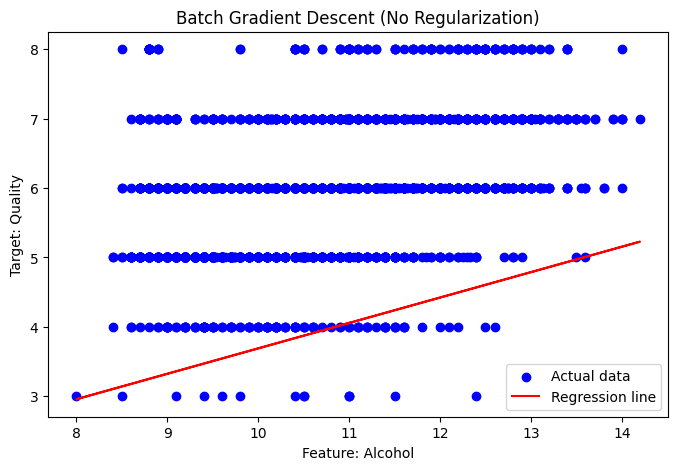

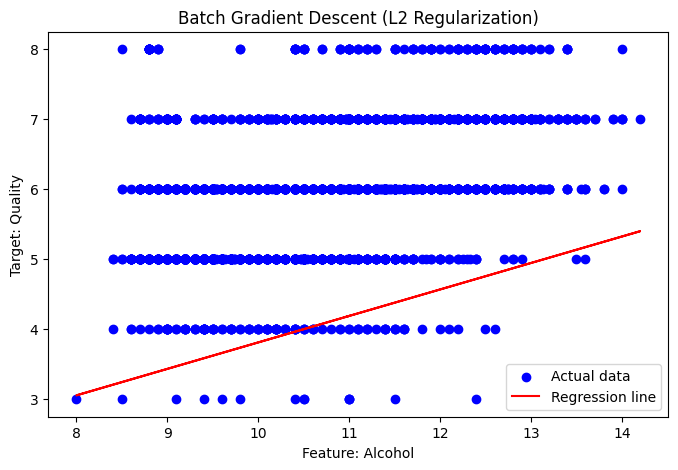

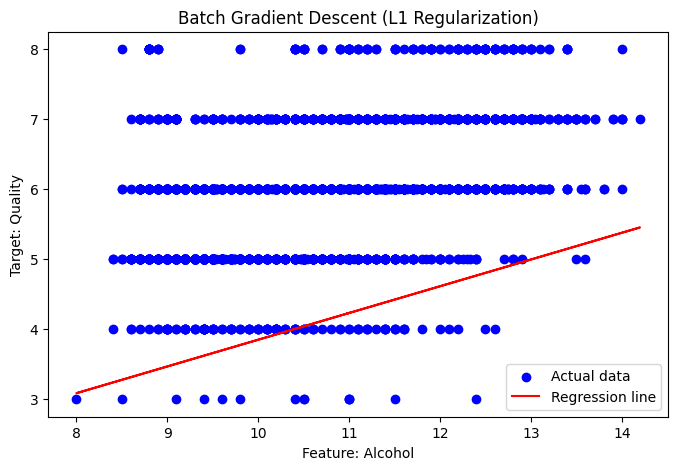

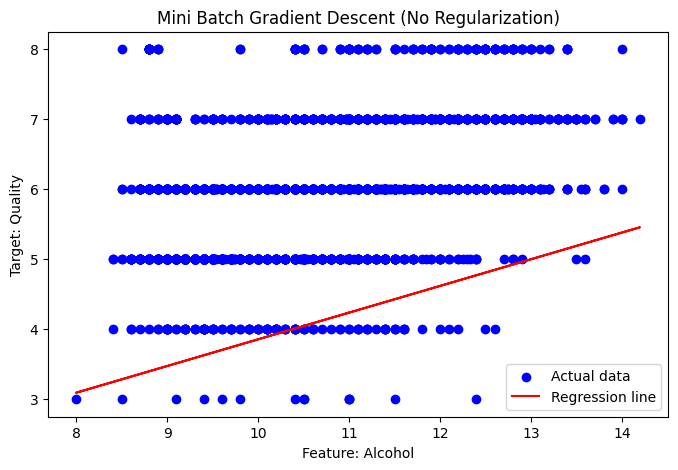

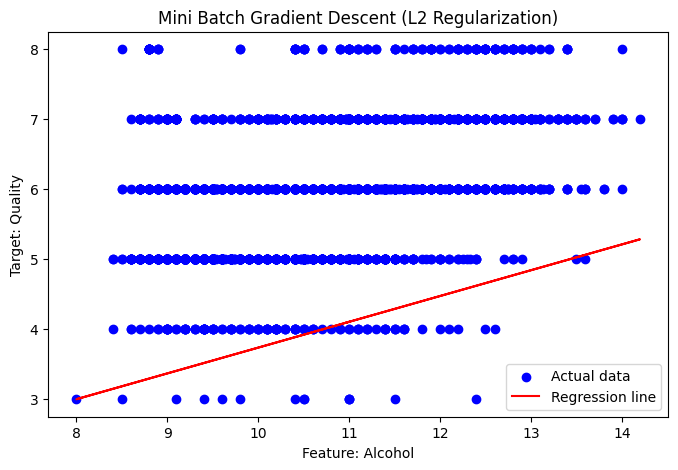

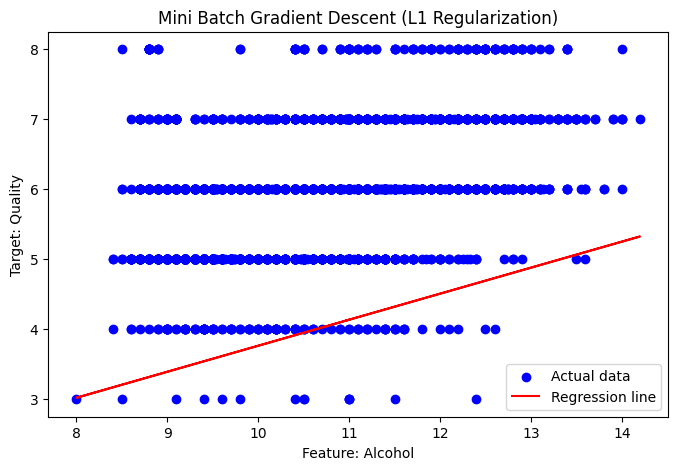

In [94]:
# Plot the regression lines
import matplotlib.pyplot as plt

def plot_regression_line(X, y, w, attribute_idx, title):
    plt.figure(figsize=(8,5))

   # Use .iloc for index-based access to the DataFrame
    plt.scatter(X.iloc[:, attribute_idx], y, color='blue', label='Actual data')

    # Calculate predicted values
    y_pred = X.iloc[:, attribute_idx] * w[attribute_idx] + w[0]  # w[0] is the bias (intercept)

    plt.plot(X.iloc[:, attribute_idx], y_pred, color='red', label='Regression line')

    plt.title(title)
    column_name= X.columns[attribute_idx]
    plt.xlabel(f'Feature: {str.capitalize(column_name)}')

    plt.ylabel('Target: Quality')

    plt.legend()

    plt.show()

# Redefine X
m, n = X_train.shape
X_train_with_bias = np.c_[np.ones((m, 1)), X_train] # Add bias term
# Use pandas to create a DataFrame with the bias term
X_train_with_bias_df = pd.DataFrame(X_train_with_bias, columns=['Bias'] + X_train.columns.tolist())


# Batch Gradient Descent (No Regularization)
max_weight_idx = np.argmax(np.abs(W_batch[1:])) + 1  # Skip the bias term
plot_regression_line(X_train_with_bias_df, Y_train, W_batch, max_weight_idx, 'Batch Gradient Descent (No Regularization)')

# Batch Gradient Descent (L2 Regularization)
max_weight_idx_l2 = np.argmax(np.abs(W_batch_l2[1:])) + 1  # Skip the bias term
plot_regression_line(X_train_with_bias_df, Y_train, W_batch_l2, max_weight_idx_l2, 'Batch Gradient Descent (L2 Regularization)')

# Batch Gradient Descent (L1 Regularization)
max_weight_idx_l1 = np.argmax(np.abs(W_batch_l1[1:])) + 1  # Skip the bias term
plot_regression_line(X_train_with_bias_df, Y_train, W_batch_l1, max_weight_idx_l1, 'Batch Gradient Descent (L1 Regularization)')

# Mini_Batch Gradient Descent (No Regularization)
max_weight_idx_mini = np.argmax(np.abs(W_mini_batch[1:])) + 1  # Skip the bias term
plot_regression_line(X_train_with_bias_df, Y_train, W_mini_batch, max_weight_idx_mini, 'Mini Batch Gradient Descent (No Regularization)')

# Mini_Batch Gradient Descent (L2 Regularization)
max_weight_idx_l2_mini = np.argmax(np.abs(W_mini_batch_l2[1:])) + 1  # Skip the bias term
plot_regression_line(X_train_with_bias_df, Y_train, W_mini_batch_l2, max_weight_idx_l2_mini, 'Mini Batch Gradient Descent (L2 Regularization)')

# Mini_Batch Gradient Descent (L1 Regularization)
max_weight_idx_l1_mini = np.argmax(np.abs(W_mini_batch_l1[1:])) + 1  # Skip the bias term
plot_regression_line(X_train_with_bias_df, Y_train, W_mini_batch_l1, max_weight_idx_l1_mini, 'Mini Batch Gradient Descent (L1 Regularization)')


In [95]:
# Evaluate model based on test data set
def evaluate_model(W, X_test, Y_test):
    X_test = np.c_[np.ones((X_test.shape[0], 1)), X_test]  # Add bias term for test set
    # Compute predictions for the test set
    Y_test_hat = np.dot(X_test, W)  # Calculate predictions
    # Calculate Mean Squared Error (MSE)
    test_mse = np.mean((Y_test - Y_test_hat) ** 2)
    test_rmse = np.sqrt(test_mse)
    return Y_test_hat, test_rmse


In [96]:
# Test evaluation for Batch Gradient Descent Algorithms
Y_test_hat, test_rmse = evaluate_model(W_batch, X_test, Y_test)
print(f"Test RMSE for Batch Gradient Descent without Regularization: {test_rmse}")

# Assuming W_batch has the bias term included and X_test is properly formatted with the bias term
Y_test_hat_l2, test_rmse_l2 = evaluate_model(W_batch_l2, X_test, Y_test)
print(f"Test RMSE for Batch Gradient Descent with L2 Regularization: {test_rmse_l2}")

# Assuming W_batch has the bias term included and X_test is properly formatted with the bias term
Y_test_hat_l1, test_rmse_l1 = evaluate_model(W_batch_l1, X_test, Y_test)
print(f"Test RMSE for Batch Gradient Descent with L1 Regularization: {test_rmse_l1}")

Test RMSE for Batch Gradient Descent without Regularization: 0.8122098210958061
Test RMSE for Batch Gradient Descent with L2 Regularization: 0.807512786417244
Test RMSE for Batch Gradient Descent with L1 Regularization: 0.8066831675577979


In [97]:
# Test evaluation for Mini Batch Gradient Descent Algorithms
Y_test_hat_mini, test_rmse_mini = evaluate_model(W_mini_batch, X_test, Y_test)
# Calculate Mean Squared Error (MSE) for the test predictions
test_mse_mini = np.mean((Y_test - Y_test_hat_mini) ** 2)
print(f"Test RMSE for Mini Batch Gradient Descent without Regularization: {test_rmse_mini}")

# Assuming W_batch has the bias term included and X_test is properly formatted with the bias term
Y_test_hat_l2_mini, test_rmse_l2_mini = evaluate_model(W_mini_batch_l2, X_test, Y_test)
# Calculate Mean Squared Error (MSE) for the test predictions
test_mse_l2_mini = np.mean((Y_test - Y_test_hat_l2_mini) ** 2)
print(f"Test RMSE for Mini Batch Gradient Descent with L2 Regularization: {test_rmse_l2_mini}")

# Assuming W_batch has the bias term included and X_test is properly formatted with the bias term
Y_test_hat_l1_mini, test_rmse_l1_mini = evaluate_model(W_mini_batch_l1, X_test, Y_test)
# Calculate Mean Squared Error (MSE) for the test predictions
test_mse_l1_mini = np.mean((Y_test - Y_test_hat_l1_mini) ** 2)
print(f"Test RMSE for Mini Batch Gradient Descent with L1 Regularization: {test_rmse_l1_mini}")

Test RMSE for Mini Batch Gradient Descent without Regularization: 0.8310553855474135
Test RMSE for Mini Batch Gradient Descent with L2 Regularization: 0.828460705634854
Test RMSE for Mini Batch Gradient Descent with L1 Regularization: 0.8290072827974957


In [98]:
# Test evaluation for Batch Gradient Descent Algorithms with elimination of the feature having smallest W_hat
# Remove the feature corresponding to the smallest weight from the test set
X_test_reduced_l2 = np.delete(X_test, min_weight_idx_batch_l2 - 1, axis=1) 
# Evaluate the model on the reduced test set using the weights from L2 regularization
Y_test_reduced_hat_l2, test_reduced_rmse_l2 = evaluate_model(W_batch_l2_reduced, X_test_reduced_l2, Y_test)
print(f"Test RMSE for Batch Gradient Descent with L2 Regularization after removing one feature: {test_reduced_rmse_l2}")

# Test evaluation for Batch Gradient Descent Algorithms with elimination of the feature having smallest W_hat
# Remove the feature corresponding to the smallest weight from the test set
X_test_reduced_l1 = np.delete(X_test, min_weight_idx_batch_l1 - 1, axis=1)  # Removing column from X_test (subtract 1 to match 0-indexing)
# Evaluate the model on the reduced test set using the weights from L2 regularization
Y_test_reduced_hat_l1, test_reduced_rmse_l1 = evaluate_model(W_batch_l1_reduced, X_test_reduced_l1, Y_test)
print(f"Test RMSE for Batch Gradient Descent with L1 Regularization after removing one feature: {test_reduced_rmse_l1}")

Test RMSE for Batch Gradient Descent with L2 Regularization after removing one feature: 0.8075128172386209
Test RMSE for Batch Gradient Descent with L1 Regularization after removing one feature: 0.8066831906658831
